# Analysis of Human Driving Behavior
Human behavior tends to be unique and every human seems to leave a fingerprint in different actions they
perform which can be decoded through behavior analysis, similar to other activities leaving the human’s fingerprints, driving style is also a personalized and unique trait of each individual, research shows that humans exhibit different driving behaviors even in plain and traffic-free terrains.
Modern vehicles are equipped with computers onboard and with ICT development, modern vehicles are also connected to the internet.

I will explore the door that it opens to protecting vehicles against theft. With computers on board, it is possible to record several aspects of a human’s driving aspects which can be used for behavioral analysis
and a profile of the driver can be created, the same profile can be used to detect vehicle theft when there is a swift change in driving patterns and then appropriate actions can be performed to counter the theft. In this paper 

## Dataset
I use a data set from HCRL, which contains driving data of ten drivers on the same route, I will perform the required data cleansing
to remove the less important features of a human’s driving behavior, as well as remove some data which seems to be invalid or corrupt, after which exploratory analysis is performed to analyze different aspects of human driving behavior and establish a profile. The profile can later be used to detect if the current driver’s driving behavior does not match with
the established profile, thus, indicating a theft. Since driving is a time-dependent action and not a one-off attribute, a driver must drive for a minimum required duration or distance to be able to be classified into the owner/thief class.


## Repository:

https://github.com/abfarooq/driving_data_project



In [ ]:
# In this section I download and import all the required modules

!pip3 install pyspark

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
#using google drive system to upload files
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# creating java bins for oc46 errors being received.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark
findspark.init()

#let us check where spark is installed. 
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
# now, I will create a spark session that will help in Exploratory data Analysis. 
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('Driving Data Analysis').getOrCreate()
spark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#let us print the spark and check whether it is working properly or not. 
spark

In [ ]:
# loading the csv file in spark 
df = spark.read.csv("/content/Driving_Data(KIA_SOUL)1.csv", header=True, inferSchema=True)

# Understanding the Data for Analysis

The first step in data analysis has to be understanding your data, it is important to analyze the data from different aspects, understanding all the dimensions it provides.
The dataset I use has been taken from HCRL, the dataset includes a driving time of about twenty-three hours, driving length of around forty-six kilometers and driving behaviour of ten drivers. The data-set comes with 51 features data has been recorded per second of driving.


Using spark's printSchema(), I will view the schema which will give me some information about the columns/features in the dataset.

In [ ]:
df.printSchema()

root
 |-- Fuel_consumption: double (nullable = true)
 |-- Accelerator_Pedal_value: double (nullable = true)
 |-- Throttle_position_signal: double (nullable = true)
 |-- Short_Term_Fuel_Trim_Bank1: double (nullable = true)
 |-- Intake_air_pressure: integer (nullable = true)
 |-- Filtered_Accelerator_Pedal_value: integer (nullable = true)
 |-- Absolute_throttle_position: double (nullable = true)
 |-- Engine_soacking_time: integer (nullable = true)
 |-- Inhibition_of_engine_fuel_cut_off: integer (nullable = true)
 |-- Engine_in_fuel_cut_off: integer (nullable = true)
 |-- Fuel_Pressure: integer (nullable = true)
 |-- Long_Term_Fuel_Trim_Bank1: double (nullable = true)
 |-- Engine_speed: integer (nullable = true)
 |-- Engine_torque_after_correction: double (nullable = true)
 |-- Torque_of_friction: double (nullable = true)
 |-- Flywheel_torque_(after_torque_interventions): double (nullable = true)
 |-- Current_spark_timing: double (nullable = true)
 |-- Engine_coolant_temperature17: intege

from spark's show() I can have a quick look over the data I am working with, it can be seen that most columns have data in integer/double format.

In [ ]:
df.show(5)

+----------------+-----------------------+------------------------+--------------------------+-------------------+--------------------------------+--------------------------+--------------------+---------------------------------+----------------------+-------------+-------------------------+------------+------------------------------+------------------+--------------------------------------------+--------------------+----------------------------+------------------------+-------------+---------------------+-------------------------------+-------------------------------+---------------+--------------------------------------+---------------------+-------------------------------------+--------------------------------------+---------------------------------+------------------------------------------+-------------------------+----------------------------+----------------------+------------+----------------------------+------------------------------+------------------------------+------------

I will check the total number of rows by calling spark's count() function.

In [ ]:
df.count()

94380

Using spark I can view some aggregated information about my data, as can be seen we have the mean, count, standard deviation, minimum and maximum values for each column. While the data seems to be in a good shape, it will certainly need scaling. 

In [ ]:
df.describe().show()


+-------+-----------------+-----------------------+------------------------+--------------------------+-------------------+--------------------------------+--------------------------+--------------------+---------------------------------+----------------------+-------------+-------------------------+------------------+------------------------------+------------------+--------------------------------------------+--------------------+----------------------------+------------------------+------------------+---------------------+-------------------------------+-------------------------------+------------------+--------------------------------------+---------------------+-------------------------------------+--------------------------------------+---------------------------------+------------------------------------------+-------------------------+----------------------------+----------------------+------------------+----------------------------+------------------------------+--------------

We generally don't want to deal with null values, therefore, I will drop the rows containing null values.

In [ ]:
df.na.drop().show()

+----------------+-----------------------+------------------------+--------------------------+-------------------+--------------------------------+--------------------------+--------------------+---------------------------------+----------------------+-------------+-------------------------+------------+------------------------------+------------------+--------------------------------------------+--------------------+----------------------------+------------------------+-------------+---------------------+-------------------------------+-------------------------------+---------------+--------------------------------------+---------------------+-------------------------------------+--------------------------------------+---------------------------------+------------------------------------------+-------------------------+----------------------------+----------------------+------------+----------------------------+------------------------------+------------------------------+------------

During the manual analysis of data, I found that the Current_Gear column contains some values that don't seem realistic. Such as drivers driving in gear number 14th, therefore I am filtering my data to only work with gear numbers equal to or less than 6.

In [ ]:
df_filtered = df[df['Current_Gear'] <= 6]

After filtering we are left with 93457 rows which means 833 rows had an inappropriate gear numbers and, therefore, filtered out.

In [ ]:
#checking the count of rows removed from df
df_filtered.count()

93457

In [ ]:
df_filtered.describe().show()


+-------+-----------------+-----------------------+------------------------+--------------------------+-------------------+--------------------------------+--------------------------+--------------------+---------------------------------+----------------------+-------------+-------------------------+------------------+------------------------------+------------------+--------------------------------------------+--------------------+----------------------------+------------------------+------------------+---------------------+-------------------------------+-------------------------------+------------------+--------------------------------------+---------------------+-------------------------------------+--------------------------------------+---------------------------------+------------------------------------------+-------------------------+----------------------------+----------------------+------------------+----------------------------+------------------------------+--------------

In [ ]:
from pyspark.sql import functions as F

df_filtered.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()


+----------------+-----------------------+------------------------+--------------------------+-------------------+--------------------------------+--------------------------+--------------------+---------------------------------+----------------------+-------------+-------------------------+------------+------------------------------+------------------+--------------------------------------------+--------------------+----------------------------+------------------------+-------------+---------------------+-------------------------------+-------------------------------+---------------+--------------------------------------+---------------------+-------------------------------------+--------------------------------------+---------------------------------+------------------------------------------+-------------------------+----------------------------+----------------------+------------+----------------------------+------------------------------+------------------------------+------------

In [ ]:
# Now saving the cleaned data into pandas df
df_pd = df_filtered.toPandas()
df_pd.to_csv("/content/drive/My Drive/pandas_preprocessed_data.csv")

csv_file = "/content/drive/My Drive/pandas_preprocessed_data.csv"

flights = (spark.read.format("csv")
.option("inferSchema", "true")
.option("header", "true")
.load(csv_file))
flights.createOrReplaceTempView("flights")

In [ ]:
# to get the number of partitions spark created for our data
df.rdd.getNumPartitions()


2

Using spark I will query to find out the total number of distinct drivers and the rows we have for each driver. 

+-----------+-------+
|count_class|class_d|
+-----------+-------+
|      10888|      F|
|       8363|      E|
|      12712|      B|
|      13167|      D|
|       7388|      C|
|       8819|      J|
|       7161|      A|
|       7373|      G|
|       7754|      I|
|       9832|      H|
+-----------+-------+



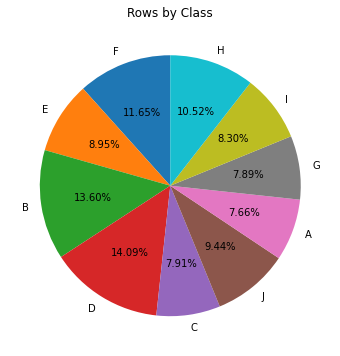

In [ ]:
query = "SELECT COUNT(class) count_class, class as class_d from flights GROUP BY class_d"
df_1 = spark.sql(query)
df_1.show()
df_1 = df_1.toPandas()



labels = df_1.class_d
sections = df_1.count_class

import matplotlib.pyplot as plt
plt.pie(sections, labels=labels,
        startangle=90,
        
        autopct = '%1.2f%%')

plt.title('Rows by Class')
plt = plt.gcf()
plt.set_size_inches(6,6)
plt.show()




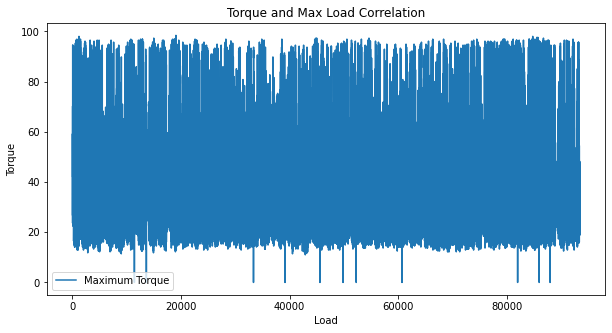

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k')
x_vals = df_pd["Calculated_LOAD_value"]
plt.plot(x_vals, label="Maximum Torque")
plt.ylabel('Torque')
plt.xlabel('Load')
plt.title("Torque and Max Load Correlation")
plt.legend()
plt.show()

In [ ]:
query_speed = "SELECT max(vehicle_speed) max_vehicle_speed from flights WHERE class= 'A' UNION SELECT max(vehicle_speed) from flights WHERE class= 'B' UNION SELECT max(vehicle_speed) from flights WHERE class= 'C' UNION SELECT max(vehicle_speed) from flights WHERE class= 'D' UNION SELECT max(vehicle_speed) from flights WHERE class= 'E' UNION SELECT max(vehicle_speed) from flights WHERE class= 'F'"
df_speed = spark.sql(query_speed)
df_speed = df_speed.toPandas()



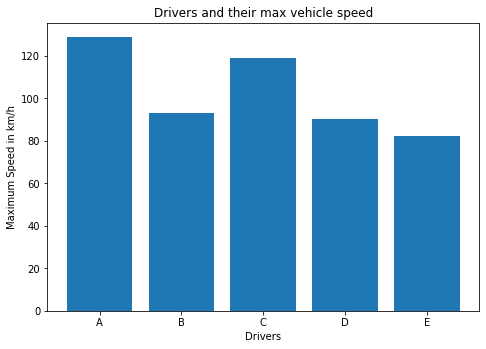

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
drivers = ['A', 'B', 'C', 'D', 'E']
ax.bar(drivers, df_speed["max_vehicle_speed"])


plt.ylabel('Maximum Speed in km/h')
plt.xlabel('Drivers')
plt.title("Drivers and their max vehicle speed")
plt.show()


It can be seen that different drivers hit different top speeds even in the same terrain with similar traffic conditions, which means max vehicle speed can be used as an important feature in distinguishing between driving profiles. 

+------------------+
|   average_soaking|
+------------------+
|  57.0141041753945|
|1.2870516047828824|
| 70.55278830536004|
|2.8196248196248197|
| 85.82063852684443|
|3.5199301983835416|
|2.4587006645870066|
| 70.04861676159479|
+------------------+



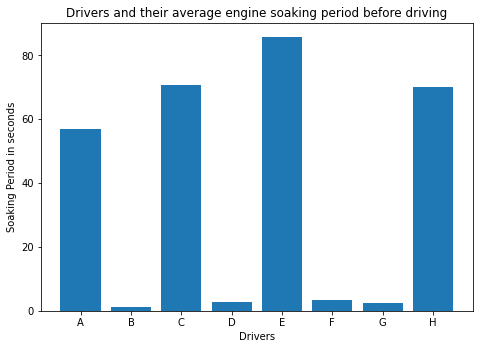

In [ ]:
query_soaking_time = "SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='A' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='B' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='C' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='D' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='E' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='F' UNION SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='G' UNION  SELECT AVG (Engine_soacking_time) average_soaking FROM flights WHERE class ='H'"
df_soak = spark.sql(query_soaking_time)
df_soak.show()
df_soak = df_soak.toPandas()
#Engine_soacking_time

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
drivers = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
ax.bar(drivers, df_soak["average_soaking"])

plt.ylabel('Soaking Period in seconds')
plt.xlabel('Drivers')
plt.title("Drivers and their average engine soaking period before driving")

plt.show()

Sensors in the vehicle can record the time, drivers give for their vehicles' engines before driving. It can be analyzed from the data that the soaking period ranges from <10 seconds to over 60 seconds in drivers. 
The variance makes this features an important one to determine between drivers.

In [ ]:
query_speed_torque = "SELECT vehicle_speed, Torque_converter_speed  from flights   ORDER BY RAND() LIMIT 10"
df_speed_torque = spark.sql(query_speed_torque)
df_speed_torque.show()
df_speed_torque = df_speed_torque.toPandas()




+-------------+----------------------+
|vehicle_speed|Torque_converter_speed|
+-------------+----------------------+
|           20|                1883.5|
|           16|                1542.8|
|            0|                   0.0|
|            0|                   0.0|
|           27|                1319.0|
|           24|                1557.0|
|            0|                  31.0|
|           13|                1303.0|
|           51|                1767.3|
|           76|                2030.3|
+-------------+----------------------+



We can analyse the relation between the vehicle's top speed acheived and the engine torque reading for the moment. 

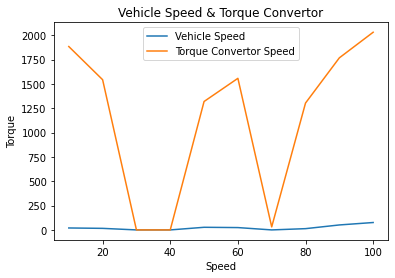

In [ ]:
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = df_speed_torque["vehicle_speed"]
y2 = df_speed_torque["Torque_converter_speed"]
import matplotlib.pyplot as plt
plt.plot(x, y1, label="Vehicle Speed")
plt.plot(x, y2, label="Torque Convertor Speed")
plt.plot()

plt.xlabel("Speed")
plt.ylabel("Torque")
plt.title("Vehicle Speed & Torque Convertor")
plt.legend()
plt.show()

It can be seen that the vehicle speed and the vehicle's torque convertor are quite correlated.

In [ ]:
query_speed_driver_a = "SELECT vehicle_speed, class from flights WHERE class = 'A' ORDER BY vehicle_speed DESC LIMIT 20"
df_speed_a = spark.sql(query_speed_driver_a)
df_speed_a = df_speed_a.toPandas()

query_speed_driver_b = "SELECT vehicle_speed, class from flights WHERE class = 'B' ORDER BY vehicle_speed DESC LIMIT 20"
df_speed_b = spark.sql(query_speed_driver_b)
df_speed_b = df_speed_b.toPandas()

query_speed_driver_c = "SELECT vehicle_speed, class from flights WHERE class = 'C' ORDER BY vehicle_speed DESC LIMIT 20"
df_speed_c = spark.sql(query_speed_driver_c)
df_speed_c = df_speed_c.toPandas()

query_speed_driver_d = "SELECT vehicle_speed, class from flights WHERE class = 'D' ORDER BY vehicle_speed DESC LIMIT 20"
df_speed_d = spark.sql(query_speed_driver_d)
df_speed_d = df_speed_d.toPandas()

query_speed_driver_e = "SELECT vehicle_speed, class from flights WHERE class = 'E' ORDER BY vehicle_speed DESC LIMIT 20"
df_speed_e = spark.sql(query_speed_driver_e)
df_speed_e = df_speed_e.toPandas()

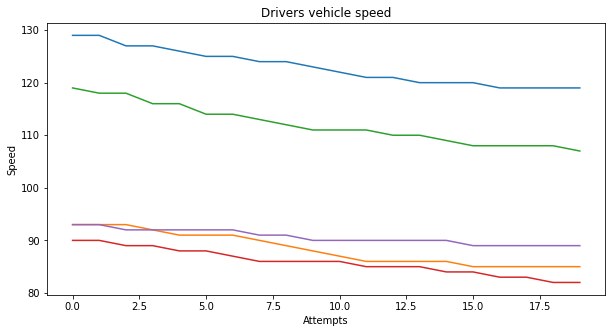

In [ ]:
# setup the data
a_vals = df_speed_a["vehicle_speed"]
b_vals = df_speed_b["vehicle_speed"]
c_vals = df_speed_c["vehicle_speed"]
d_vals = df_speed_d["vehicle_speed"]
e_vals = df_speed_e["vehicle_speed"]

import matplotlib.pyplot as plt
# plot the data
plt.figure(figsize=(10, 5))
plt.plot(a_vals)
plt.plot(b_vals)
plt.plot(c_vals)
plt.plot(d_vals)
plt.plot(e_vals)

plt.ylabel('Speed')
plt.xlabel('Attempts')
plt.title("Drivers vehicle speed")

plt.show()

One important behaviour of driving is that drivers might hit a top speed but then drive back at their natural pace. This graph illustrates the average speed of drivers after they hit a top speed. 

In [ ]:
import plotly.graph_objects as go

from datetime import datetime

query_tank = "SELECT Class, max(Long_Term_Fuel_Trim_Bank1) mx, min(Long_Term_Fuel_Trim_Bank1) mn, AVG(Long_Term_Fuel_Trim_Bank1) av FROM flights GROUP by Class ORDER BY Class"
df_tank = spark.sql(query_tank)
df_tank = df_tank.toPandas()


fig = go.Figure(data=[go.Candlestick(x=df_tank.Class,
                open=df_tank.av.astype(int) + df_tank.av.astype(int) / 100 * 10  ,
                high=df_tank.mx,
                low=df_tank.mn,
                close=df_tank.av.astype(int) - df_tank.av.astype(int) / 100 * 10)
]
)


fig.update_layout(
    title='Long Term Fuel Trim Bank',
    yaxis_title='Fuel Trim Bank',
    xaxis_title='Driver',
    
)

fig.show()

In [ ]:

query_temperature = "SELECT Class, max(Intake_air_pressure) mx, min(Intake_air_pressure) mn, AVG(Intake_air_pressure) av FROM flights GROUP by Class ORDER BY Class"
df_temperature = spark.sql(query_temperature)
df_temperature = df_temperature.toPandas()


fig = go.Figure(data=[go.Candlestick(x=df_temperature.Class,
                open=df_temperature.av.astype(int) + df_temperature.av.astype(int) / 100 * 10  ,
                high=df_temperature.mx,
                low=df_temperature.mn,
                close=df_temperature.av.astype(int) - df_temperature.av.astype(int) / 100 * 10)
]
)

fig.update_layout(
    title='Air Intake Pressure by Driving Behaviour',
    yaxis_title='Air Intake Pressure',
    xaxis_title='Driver',
    
)

fig.show()

There are aspects of driving behaviour that can impact the readings of other sensors such as the long-term fuel trim, Long-term fuel trims are measured over longer time intervals by oxygen -, or air fuel ratio sensors downstream of the catalytic converter, and in practice, the signal voltages these sensors generate are not directly implicated in fuel delivery strategies [6].  In image x the candle opening and closing shows the average long term fuel trim readings by the drivers, while the wicks of the candle show the minimum and maximum readings.

+------------------+
|     average_pedal|
+------------------+
| 10.21709258483452|
|2.0303492762743907|
| 2.057322685435844|
|0.9864281916913501|
| 7.097931364342946|
|2.6003122703894195|
+------------------+



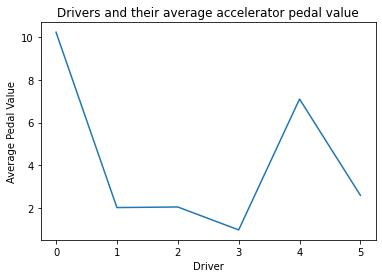

In [ ]:
query_pedal = "SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='A' UNION SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='B' UNION SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='C' UNION SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='D' UNION SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='E' UNION SELECT AVG (Accelerator_Pedal_value) average_pedal FROM flights WHERE class ='F'"

df_pedal = spark.sql(query_pedal)
df_pedal.show()
df_pedal = df_pedal.toPandas()
import matplotlib.pyplot as plt
plt.xlabel('Driver')
plt.ylabel('Average Pedal Value')

plt.title("Drivers and their average accelerator pedal value")

plt.plot(df_pedal)




How far a driver stretches out in a specific gear is yet another attribute in humans’ driving behaviour and can be used to help in the classification of drivers. It can be seen that the averagal pedal value fluctuates highly between different drivers.

In [ ]:
query_load = "SELECT Current_Gear, Engine_speed, class as driver from flights WHERE class IN ('A', 'B', 'C', 'D') AND  Current_Gear !>6  GROUP by class, Current_Gear, Engine_speed ORDER BY rand() LIMIT 1000"
df_load = spark.sql(query_load)
df_load = df_load.toPandas()

In [ ]:
import altair as alt
from vega_datasets import data
cars = df_load



alt.Chart(cars).mark_point().encode(
    x = 'Current_Gear',
    y = 'Engine_speed',
    
    color='driver',
).interactive()

alt.Chart(...)

Finally we analyze how far different drivers stretch their vehicles in a specific gear. From the data it can be seen that this feature varies highly in different drivers and therefore, can be used as an important feature in profiling. 

#Predictive Analysis
Moving onto predictive analysis, our goal is to gather the readings from the vehicle's sensors and match them to our existing driving profiles. If we find a match, we notify, otherwise, if the confidence of our model classifying the behaviour to a known profile is less than 90% then we assume the vehicle is stolen and generate a theft alert.

In [ ]:
df_pd = df.toPandas()
x = df_pd.iloc[:, :-1]
y = df_pd.iloc[:, -1]


In [ ]:
y.head

<bound method NDFrame.head of 0        A
1        A
2        A
3        A
4        A
        ..
94375    D
94376    D
94377    D
94378    D
94379    D
Name: Class, Length: 94380, dtype: object>

Before passing the data to our model, I will transform the labels.

In [ ]:

le = LabelEncoder()
y= le.fit_transform(y)




In [ ]:
# splitting the data into test and train
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)


## Principal Component Analysis
In our data set we have 51 features that I want to minimize, using PCA I get a feature list of only 15 features while still not affecting the accuracy of the model.

In [ ]:

pca = PCA(n_components=15)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)




It can be seen the features are reduced to 15.

In [ ]:

pca.explained_variance_ratio_
print("original:   ", x_train.shape)
print("transformed:", x_train_pca.shape)

original:    (70785, 52)
transformed: (70785, 15)


The data has huge variation in the values of different features, I need to scale it to make sure all features are given equal importance. 

In [ ]:

sc_x = StandardScaler()
x_trainscaled=sc_x.fit_transform(x_train)
x_testscaled=sc_x.transform(x_test)


I am using MLPClassifier to build a neural network of 32/16/8/4 hidden layers, the activation function I am using is RELU and the random state for random numbers is set to 1. 

In [ ]:

clf = MLPClassifier(hidden_layer_sizes=(32,16,8,4),activation="relu",random_state=1).fit(x_trainscaled, y_train)
y_pred=clf.predict(x_testscaled)
print(clf.score(x_testscaled, y_test))

0.9497774952320407


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



##Detect Theft
I wrote a small function that takes sensor readings and the model as a parameter, it then uses the predict_proba to findout the confidence of each class. If the confidence is greater than or equal to 90% then I assume I found a matching profile for the current driver, otherwise, if confidence is less than 90% then I assume that the vehicle has been stolen and generate a theft alert. 

In [ ]:
from detect_theft import det_theft

In [ ]:
sensor_reading = [[1100.8,0,12.2,-6.3,21,0,18.8,0,0,0,0,2.3,1654,37.5,17.2,26.3,19.9,68,930,37.5,52.2,2,75.4,25.4,230,1,15,508,0,3040,0,1,1428.5,2,46,15.6,15.6,15.7,15.5,1428.5,1,0,5,15,0.7,1,0.9,8,-0.1,8,19.7,109]]

sensor_reading2 = [[153.6,0,6.1,2.3,0,0,14.1,4,0,0,0,3.1,1486,2,10.9,9.3,-1.1,83,920,2,17.3,0,68.8,9.4,230,1,15,472,0,3040,0,0,1521.8,6,91,59.8,58.5,58.8,59.5,1522.3,1,0,5,57,-0.4,1,1.2,-0.5,0.2,0,8.5,1559]]


det_theft(sensor_reading=sensor_reading, clf=clf)
det_theft(sensor_reading=sensor_reading2, clf=clf)

You are driver #: 
[4]
You are driver #: 
[5]


I attempted to train Decision Tree Classifier for the same purpose as well and I found out that the accuracy was similar to MLP. 

In [ ]:
model = DecisionTreeClassifier()
model.fit(x_trainscaled, y_train)
y_pred = model.predict(x_testscaled)

print(accuracy_score(y_pred, y_test))
cr = classification_report(y_pred, y_test)

print(cr)

0.986013986013986
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1809
           1       0.99      0.99      0.99      3229
           2       0.97      0.98      0.98      1784
           3       0.98      0.98      0.98      3409
           4       0.99      0.99      0.99      2073
           5       0.99      0.99      0.99      2778
           6       0.99      0.99      0.99      1865
           7       0.98      0.99      0.99      2479
           8       0.99      0.99      0.99      1983
           9       0.98      0.98      0.98      2186

    accuracy                           0.99     23595
   macro avg       0.99      0.99      0.99     23595
weighted avg       0.99      0.99      0.99     23595

